# Другие модели потестировать и сравнить (точность, время выполнения)
# Дерево решений
# Также попробовать убрать цвет и потестировать

# Данный файл будет представлять из себя модель для обучения на размеченных данных о покемонах.


In [1]:
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
p = Path("./clear_dataset/")
dirs = list(p.glob('*'))

image_data = []
labels = []

image_paths = []

number_of_pokemons = 3

#pokemons_labels = [ str(el).split('\\')[-1] for el in random.sample(dirs, number_of_pokemons)]
pokemons_labels = ['Pikachu', 'Cubone', 'Meowth']

label_dict = dict(zip(pokemons_labels, [i for i in range(number_of_pokemons)]))
pokemon_label = dict(zip([i for i in range(number_of_pokemons)], pokemons_labels))
print(pokemons_labels)
print(label_dict)
print(pokemon_label)

#label_dict = {'Pikachu':0, 'Bulbasaur':1, 'Meowth':2}
#pokemon_label = {0:'Pikachu', 1:'Bulbasaur', 2:'Meowth'}

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1]
    
    count=0
    
    if label in pokemons_labels:
        print(folder_dir)
        print(label)
        for img_path in folder_dir.glob('*.jpg'):
            img = image.load_img(img_path, target_size=(200,200))
            img_array = image.img_to_array(img)
            image_data.append(img_array)

            labels.append(label_dict[label])

            count += 1

        print(count)

['Pikachu', 'Cubone', 'Meowth']
{'Pikachu': 0, 'Cubone': 1, 'Meowth': 2}
{0: 'Pikachu', 1: 'Cubone', 2: 'Meowth'}
clear_dataset\Cubone
Cubone
50
clear_dataset\Meowth
Meowth
50
clear_dataset\Pikachu
Pikachu
50


# Визуализация изображений

In [3]:
X = np.array(image_data)
Y = np.array(labels)

from sklearn.utils import shuffle
# Перемешиваем все значения
X,Y = shuffle(X,Y,random_state=42)

X = X/255.0

print(X.shape, Y.shape)

(150, 200, 200, 3) (150,)


In [7]:
X[0][0][0]

array([0.654902  , 0.53333336, 0.45490196], dtype=float32)

In [8]:
# Функция для отрисовки изображения
def drawImage(img, label):
    plt.title(pokemon_label[label])
    plt.axis('off')
    plt.style.use('seaborn')
    plt.imshow(img)
    plt.show()

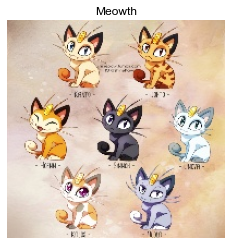

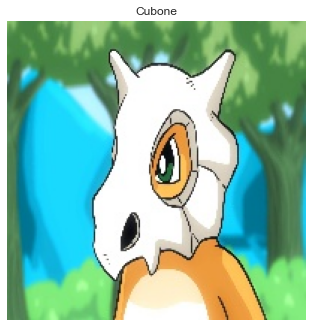

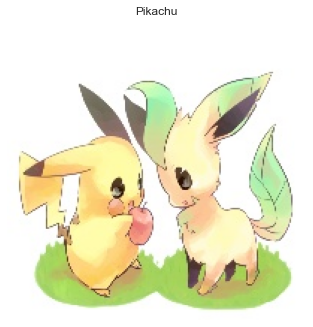

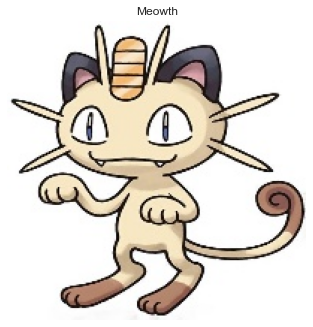

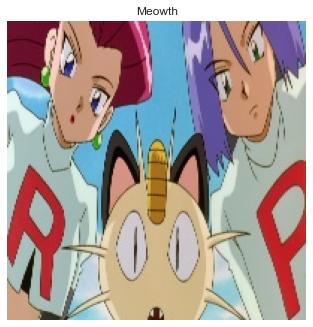

In [9]:
for i in range(0,5):
    drawImage(X[i], Y[i])

# Создаем два набора данных: для обучения и для тестирования

In [10]:
split_value = 0.8
split = int(X.shape[0] * split_value)

X_ = np.array(X)
Y_ = np.array(Y)

#Training Set
X = X_[:split,:]
Y = Y_[:split]

#Testing Set
XTest = X_[split:,:]
YTest = Y_[split:]

print(X.shape, Y.shape)
print(XTest.shape, YTest.shape)

(120, 200, 200, 3) (120,)
(30, 200, 200, 3) (30,)


# Строим нейронную сеть

In [11]:
def softmax(a):
    e_pa = np.exp(a)
    ans = e_pa/np.sum(e_pa, axis=1, keepdims=True)
    return ans

In [12]:
class NeuralNetwork:
    
    def __init__(self, input_size, layers, output_size):
        np.random.seed(0)
        
        model = {}
        
        #First Layer
        model['W1'] = np.random.randn(input_size, layers[0])
        model['b1'] = np.zeros((1, layers[0]))
        
        #Second Layer
        model['W2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1, layers[1]))
        
        #Third/Output Layer
        model['W3'] = np.random.randn(layers[1], output_size)
        model['b3'] = np.zeros((1, output_size))
        
        self.model = model
    
    def forward(self, x):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x, W1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1, W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2, W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self, x, y, learning_rate=0.001):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        a1,a2,y_ = self.activation_outputs
        m = x.shape[0]
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3, W3.T)
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2, W2.T)
        dw1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)
        
        #Update the model parameters using Gradient Descent
        self.model['W1'] -= learning_rate*dw1
        self.model['b1'] -= learning_rate*db1
        
        self.model['W2'] -= learning_rate*dw2
        self.model['b2'] -= learning_rate*db2
        
        self.model['W3'] -= learning_rate*dw3
        self.model['b3'] -= learning_rate*db3
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)
    
    def summary(self):
        
        W1,W2,W3 = self.model['W1'], self.model['W2'], self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print('W1', W1.shape)
        print('A1', a1.shape)
        
        print('W2', W2.shape)
        print('A2', a2.shape)
        
        print('W3', W3.shape)
        print('Y_', y_.shape)

In [13]:
def loss(y_oht, p):
    
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y, depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m), y] = 1
    return y_oht

In [14]:
def train(X, Y, model, epochs, learning_rate, logs=True):
    
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y, classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT, Y_)
        training_loss.append(l)
        model.backward(X, Y_OHT, learning_rate)
        
        if(logs):
            print('Epoch %d Loss %.4f' %(ix,l))
    
    return training_loss

In [15]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0], -1)
print(XTest.shape)

(120, 120000)
(30, 120000)


In [16]:
model_input_size = X.shape[-1]
my_model = NeuralNetwork(input_size=model_input_size, layers=[100,50], output_size=number_of_pokemons)

In [18]:
import time
start_time = time.time()
l = train(X=X, Y=Y, model=my_model, epochs=500, learning_rate=0.0002)
print("--- {} seconds ---".format(time.time() - start_time))

Epoch 0 Loss 0.0788
Epoch 1 Loss 0.0787
Epoch 2 Loss 0.0785
Epoch 3 Loss 0.0784
Epoch 4 Loss 0.0782
Epoch 5 Loss 0.0781
Epoch 6 Loss 0.0779
Epoch 7 Loss 0.0779
Epoch 8 Loss 0.0777
Epoch 9 Loss 0.0776
Epoch 10 Loss 0.0774
Epoch 11 Loss 0.0773
Epoch 12 Loss 0.0772
Epoch 13 Loss 0.0771
Epoch 14 Loss 0.0769
Epoch 15 Loss 0.0768
Epoch 16 Loss 0.0766
Epoch 17 Loss 0.0766
Epoch 18 Loss 0.0764
Epoch 19 Loss 0.0763
Epoch 20 Loss 0.0761
Epoch 21 Loss 0.0760
Epoch 22 Loss 0.0756
Epoch 23 Loss 0.0756
Epoch 24 Loss 0.0755
Epoch 25 Loss 0.0752
Epoch 26 Loss 0.0751
Epoch 27 Loss 0.0750
Epoch 28 Loss 0.0749
Epoch 29 Loss 0.0748
Epoch 30 Loss 0.0746
Epoch 31 Loss 0.0746
Epoch 32 Loss 0.0740
Epoch 33 Loss 0.0737
Epoch 34 Loss 0.0735
Epoch 35 Loss 0.0733
Epoch 36 Loss 0.0731
Epoch 37 Loss 0.0730
Epoch 38 Loss 0.0730
Epoch 39 Loss 0.0729
Epoch 40 Loss 0.0727
Epoch 41 Loss 0.0727
Epoch 42 Loss 0.0724
Epoch 43 Loss 0.0723
Epoch 44 Loss 0.0722
Epoch 45 Loss 0.0722
Epoch 46 Loss 0.0719
Epoch 47 Loss 0.0719
Ep

Epoch 378 Loss 0.0441
Epoch 379 Loss 0.0442
Epoch 380 Loss 0.0447
Epoch 381 Loss 0.0439
Epoch 382 Loss 0.0438
Epoch 383 Loss 0.0436
Epoch 384 Loss 0.0436
Epoch 385 Loss 0.0435
Epoch 386 Loss 0.0434
Epoch 387 Loss 0.0434
Epoch 388 Loss 0.0433
Epoch 389 Loss 0.0433
Epoch 390 Loss 0.0432
Epoch 391 Loss 0.0433
Epoch 392 Loss 0.0438
Epoch 393 Loss 0.0431
Epoch 394 Loss 0.0430
Epoch 395 Loss 0.0430
Epoch 396 Loss 0.0429
Epoch 397 Loss 0.0429
Epoch 398 Loss 0.0430
Epoch 399 Loss 0.0429
Epoch 400 Loss 0.0431
Epoch 401 Loss 0.0427
Epoch 402 Loss 0.0426
Epoch 403 Loss 0.0425
Epoch 404 Loss 0.0424
Epoch 405 Loss 0.0424
Epoch 406 Loss 0.0423
Epoch 407 Loss 0.0423
Epoch 408 Loss 0.0422
Epoch 409 Loss 0.0422
Epoch 410 Loss 0.0422
Epoch 411 Loss 0.0425
Epoch 412 Loss 0.0423
Epoch 413 Loss 0.0427
Epoch 414 Loss 0.0419
Epoch 415 Loss 0.0419
Epoch 416 Loss 0.0418
Epoch 417 Loss 0.0418
Epoch 418 Loss 0.0417
Epoch 419 Loss 0.0416
Epoch 420 Loss 0.0416
Epoch 421 Loss 0.0415
Epoch 422 Loss 0.0414
Epoch 423 

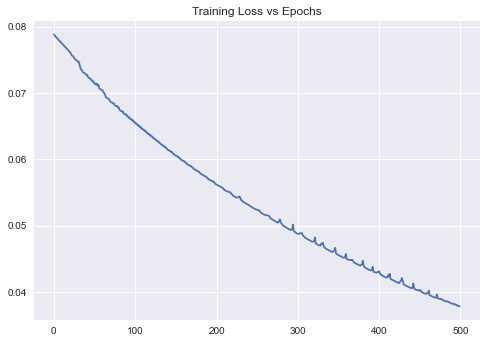

In [19]:
#plt.style.use('dark_background')
plt.title('Training Loss vs Epochs')
plt.plot(l)
plt.show()

In [20]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

print('Train Accuracy %.4f' %getAccuracy(X,Y,my_model))
print('Testing Accuracy %.4f' %getAccuracy(XTest,YTest,my_model))

Train Accuracy 0.9667
Testing Accuracy 0.3333


In [21]:
from sklearn.metrics import classification_report

In [22]:
outputs = my_model.predict(X)
print(classification_report(outputs,Y))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.95      0.98      0.96        42
           2       0.95      0.95      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [23]:
test_outputs = my_model.predict(XTest)
print(classification_report(test_outputs,YTest))

              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.00      0.00      0.00         8
           2       0.45      0.31      0.37        16

    accuracy                           0.33        30
   macro avg       0.29      0.38      0.31        30
weighted avg       0.33      0.33      0.31        30



In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [25]:
cnf_matrix = confusion_matrix(outputs,Y)
print(cnf_matrix)

df_cm = pd.DataFrame(cnf_matrix, range(number_of_pokemons), range(number_of_pokemons))
df_cm.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
print(df_cm)

[[38  0  1]
 [ 0 41  1]
 [ 0  2 37]]
         Pikachu  Cubone  Meowth
Pikachu       38       0       1
Cubone         0      41       1
Meowth         0       2      37


<AxesSubplot:>

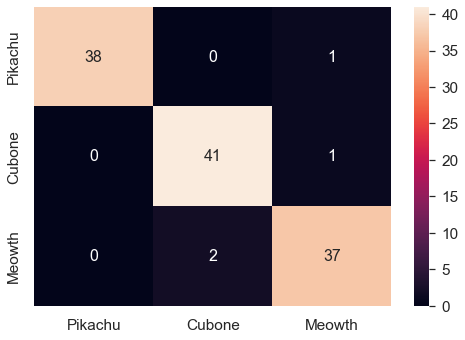

In [26]:
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [27]:
cnf_matrix_test = confusion_matrix(test_outputs,YTest)
print(cnf_matrix_test)

df_cm_test = pd.DataFrame(cnf_matrix_test, range(number_of_pokemons), range(number_of_pokemons))
df_cm_test.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
print(df_cm_test)

[[5 1 0]
 [2 0 6]
 [5 6 5]]
         Pikachu  Cubone  Meowth
Pikachu        5       1       0
Cubone         2       0       6
Meowth         5       6       5


<AxesSubplot:>

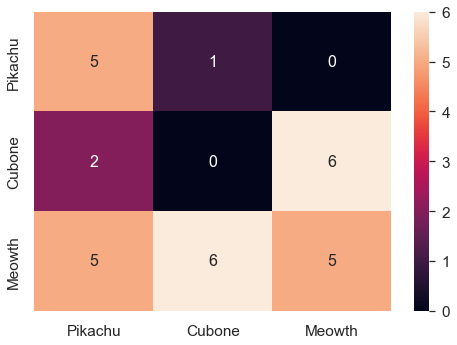

In [28]:
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 16}) # font size

# Визуализируйте ошибочные классификации

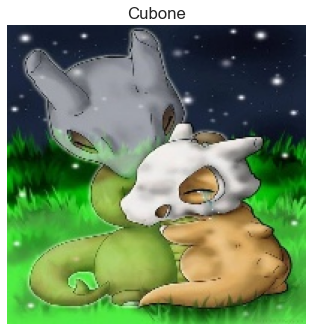

Prediction 53 Meowth


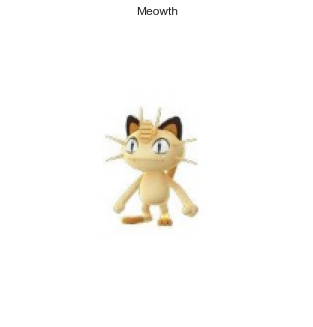

Prediction 55 Cubone


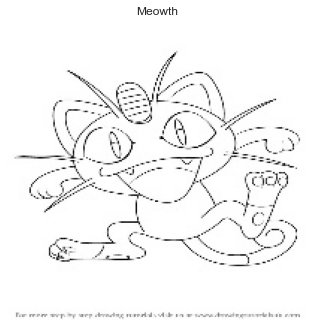

Prediction 79 Pikachu


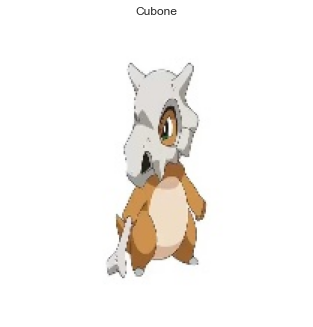

Prediction 108 Meowth


In [29]:
for i in range(Y.shape[0]):
    if Y[i] != outputs[i]:
        drawImage(X[i].reshape(200,200,3), Y[i])
        plt.show()
        print("Prediction %d %s" %(i, pokemon_label[outputs[i]]))

# Использование других моделей

In [56]:
def print_report(model, X, Y):
    from sklearn.metrics import confusion_matrix
    import seaborn as sn
    
    y_pred = model.predict(X)
    matrix = confusion_matrix(y_pred, Y)
    #print(matrix)

    df_matrix = pd.DataFrame(matrix, range(number_of_pokemons), range(number_of_pokemons))
    df_matrix.rename(columns=pokemon_label, index=pokemon_label, inplace=True)
    #print(df_matrix)
    
    sn.set(font_scale=1.4)
    sn.heatmap(df_matrix, annot=True, annot_kws={"size": 16})
    print(classification_report(y_pred,Y))
    return y_pred

In [57]:
from sklearn.model_selection import learning_curve
def print_learning_curve(model, x_train, y_train, train_sizes):
    _, train_scores, test_scores = learning_curve(model, x_train, y_train, train_sizes=train_sizes, cv=3)
    print(np.mean(test_scores,axis=1))
    
    plt.figure('Learning Curve')
    plt.title('Learning Curve')
    plt.xlabel('train size')
    plt.ylabel('F1 score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Learning Curve', color='red')
    plt.legend()
    plt.show()

In [71]:
def print_misidentifications(X, Y, y_pred):
    # Демонстрация несоответствий
    for i in range(Y.shape[0]):
        if Y[i] != y_pred[i]:
            drawImage(X[i].reshape(200,200,3), Y[i])
            plt.show()
            print("Prediction %d %s" %(i, pokemon_label[y_pred[i]]))

# Метод опорных векторов (линейное ядро)

In [58]:
from sklearn import svm

clf_lin = svm.SVC(kernel='linear') # метод опорных векторов с линейным ядром 
clf_lin.fit(X, Y)

SVC(kernel='linear')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        39

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



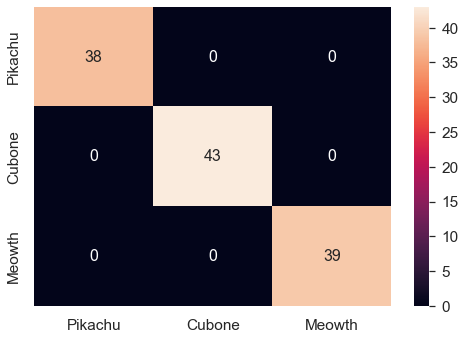

In [59]:
y_pred_vec_lin = print_report(clf_lin, X, Y) # Обучение

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.86      0.60      0.71        10
           2       0.82      0.90      0.86        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.82        30
weighted avg       0.84      0.83      0.82        30



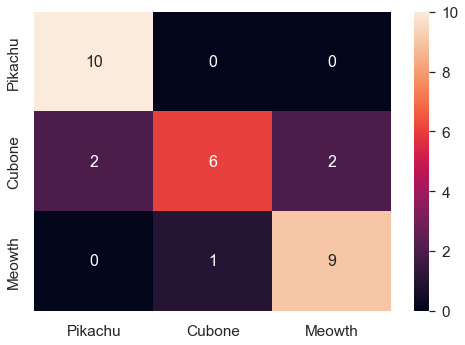

In [60]:
y_pred_vec_lin_test = print_report(clf_lin, XTest, YTest) # Проверка

[0.475      0.59166667 0.68333333 0.69166667 0.68333333 0.725
 0.68333333 0.66666667 0.725      0.725     ]


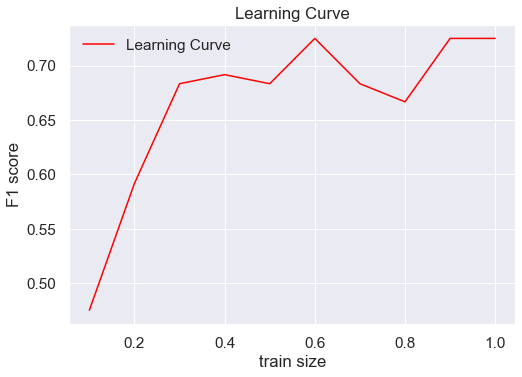

In [69]:
print_learning_curve(clf_lin, X, Y, train_sizes=np.linspace(0.1, 1, 10))

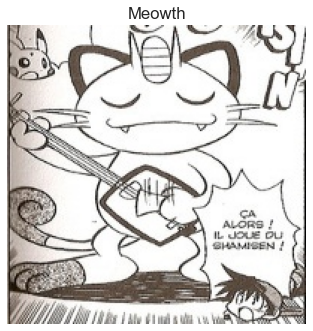

Prediction 5 Cubone


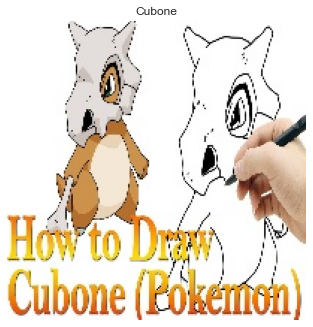

Prediction 8 Meowth


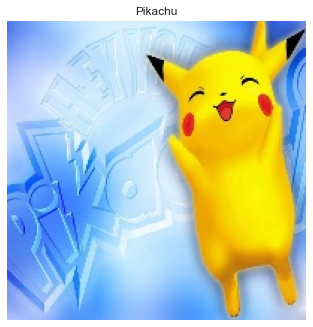

Prediction 11 Cubone


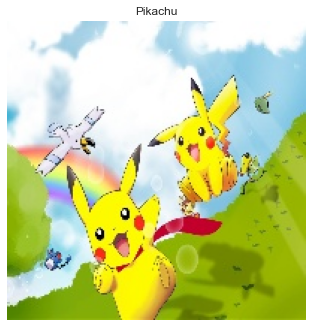

Prediction 17 Cubone


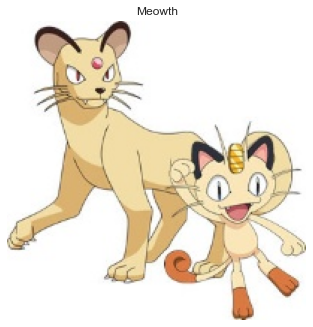

Prediction 25 Cubone


In [72]:
print_misidentifications(XTest, YTest, y_pred_vec_lin_test)

# Метод опорных векторов (Гауссово ядро)

In [65]:
from sklearn import svm

clf_gaus = svm.SVC(kernel='rbf')
clf_gaus.fit(X, Y)

SVC()

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       1.00      0.96      0.98        45
           2       0.97      1.00      0.99        38

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



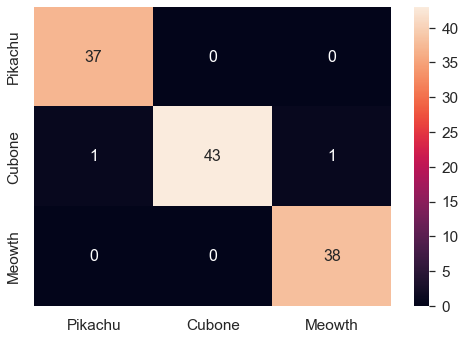

In [66]:
y_pred_vec_gaus = print_report(clf_gaus, X, Y) # Обучение

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.86      0.55      0.67        11
           2       0.64      0.78      0.70         9

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



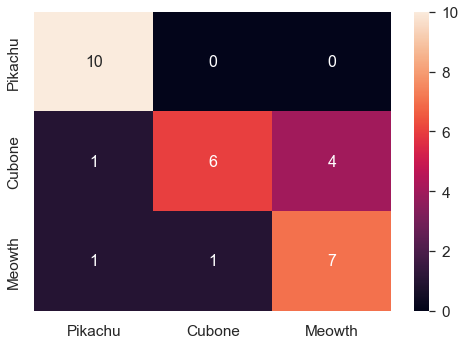

In [68]:
y_pred_vec_gaus_test = print_report(clf_gaus, XTest, YTest) # Тестирование

[0.35       0.31666667 0.36666667 0.45833333 0.49166667 0.5
 0.55833333 0.55       0.65       0.65833333]


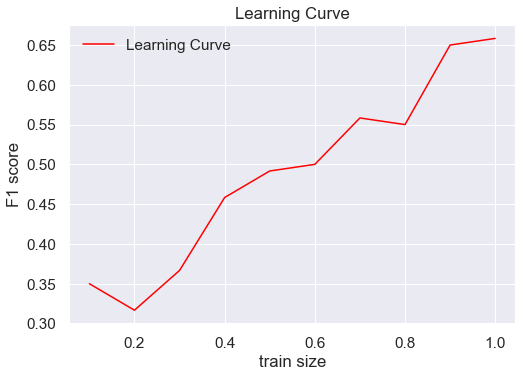

In [70]:
print_learning_curve(clf_gaus, X, Y, train_sizes=np.linspace(0.1, 1, 10))

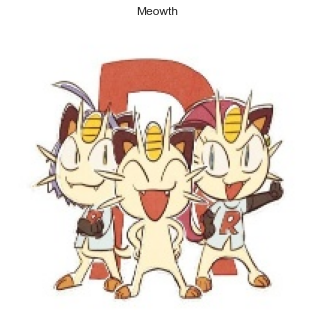

Prediction 3 Cubone


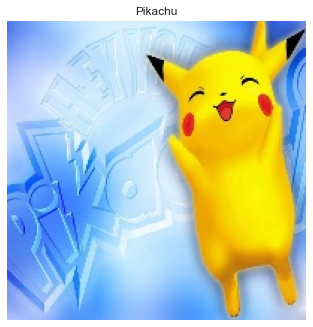

Prediction 11 Meowth


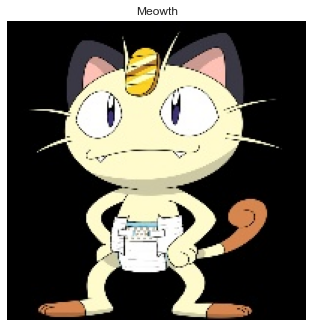

Prediction 15 Cubone


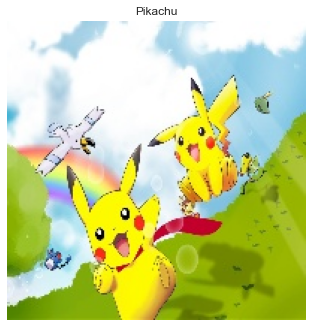

Prediction 17 Cubone


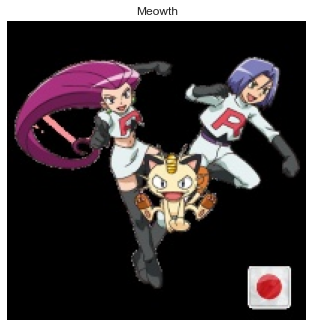

Prediction 20 Cubone


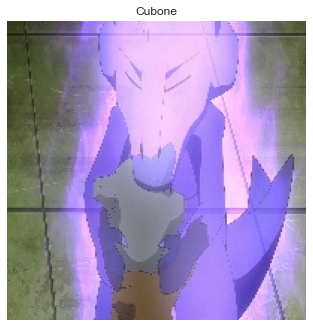

Prediction 24 Meowth


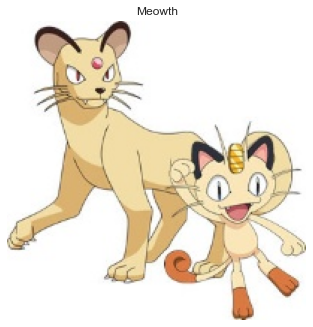

Prediction 25 Cubone


In [73]:
print_misidentifications(XTest, YTest, y_pred_vec_gaus_test)

# Метод k ближайших соседей

# Многослойный перцептрон
